# Investigating the step change in behaviour with lead time apparent in the forecasts in 2005

In [1]:
import glob

import dask

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
from xmovie import Movie

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from matplotlib import gridspec

In [3]:
cartopy.config["pre_existing_data_dir"] = "/g/data/xv83/users/ds0092/data/cartopy-data"
cartopy.config["data_dir"] = "/g/data/xv83/users/ds0092/data/cartopy-data"

In [4]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/xmovie/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.24.66:8787/status,
Dashboard: http://10.6.24.66:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.24.66:40839,Workers: 0
Dashboard: http://10.6.24.66:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [18]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


### Load CAFE-f6 hindcasts

In [7]:
def open_mfzarr(files, preprocess=None, parallel=False, **open_kwargs):
    """Open multiple zarr files applying a preprocess step prior to merging

    NOTE: for some reason, using parallel=True produces cftime.datetime objects
    that break with DatatimeAccessor methods like dt.floor. Opening the data in
    serial does not, see https://github.com/pydata/xarray/issues/6026
    """
    open_zarr_ = dask.delayed(xr.open_zarr) if parallel else xr.open_zarr
    preprocess_ = dask.delayed(preprocess) if parallel else preprocess
    open_tasks = [open_zarr_(f, **open_kwargs) for f in files]
    preprocess_tasks = (
        [preprocess_(task) for task in open_tasks]
        if preprocess is not None
        else open_tasks
    )
    datasets = dask.compute(preprocess_tasks)[0] if parallel else preprocess_tasks
    return xr.combine_by_coords(
        datasets, compat="override", coords="minimal"
    ).unify_chunks()

In [8]:
def round_to_start_of_month(ds, dim):
    """Return provided array with specified time dimension rounded to the start of
    the month
    """
    from xarray.coding.cftime_offsets import MonthBegin

    return ds.assign_coords({dim: ds[dim].dt.floor("D") - MonthBegin()})


def convert_time_to_lead(ds, time_dim="time", init_dim="init", lead_dim="lead"):
    """Return provided array with time dimension converted to lead time dimension
    and time added as additional coordinate
    """
    init_date = ds[time_dim].time[0].item()
    lead_time = range(len(ds[time_dim]))
    time_coord = (
        ds[time_dim]
        .rename({time_dim: lead_dim})
        .assign_coords({lead_dim: lead_time})
        .expand_dims({init_dim: [init_date]})
    )
    dataset = ds.rename({time_dim: lead_dim}).assign_coords(
        {lead_dim: lead_time, init_dim: [init_date]}
    )
    dataset = dataset.assign_coords({time_dim: time_coord})
    return dataset


def coarsen_monthly_to_annual(ds, start_point=None, dim="time"):
    """Coarsen monthly data to annual, applying 'max' to all relevant coords and
    optionally starting at a particular point in the array
    """
    aux_coords = [c for c in ds.coords if dim in ds[c].dims]
    return (
        ds.sel({dim: slice(start_point, None)})
        .coarsen({dim: 12}, boundary="trim", coord_func={d: "max" for d in aux_coords})
        .mean()
    )


def truncate_latitudes(ds, dp=10):
    """Return provided array with latitudes truncated to specified dp.

    This is necessary due to precision differences from running forecasts on
    different systems
    """
    for dim in ds.dims:
        if "lat" in dim:
            ds = ds.assign_coords({dim: ds[dim].round(decimals=dp)})
    return ds


def preprocess_CAFEf6_monthly_to_annual(ds):
    """Preprocessing steps for CAFE-f6 data"""

    ds = round_to_start_of_month(ds, dim="time")
    ds = convert_time_to_lead(ds)

    # Convert to annual data
    ds = coarsen_monthly_to_annual(ds, dim="lead")

    # Truncate lats so that forecasts run on different systems can be stacked
    ds = truncate_latitudes(ds)

    # Required by climpred
    ds = ds.rename({"ensemble": "member"})
    ds["lead"].attrs["units"] = "months"
    return ds

In [9]:
data_dir = "/g/data/xv83/dcfp/CAFE-f6"
realm = "atmos_isobaric_month.zarr.zip"

files = sorted(glob.glob(f"{data_dir}/c5-d60-pX-f6-*/{realm}"))

In [10]:
cafe_hcst = open_mfzarr(
    files, preprocess=preprocess_CAFEf6_monthly_to_annual, parallel=False
)["t_surf"]

# cafe_hcst = cafe_hcst.drop("time")  # Req by climpred

HCST_CHUNKS = {"init": -1, "lead": 1}
cafe_hcst = cafe_hcst.chunk(HCST_CHUNKS).persist()

# Plot strange behaviour in forecasts

In [66]:
hcst_gbl = (
    cafe_hcst.sel(lat=slice(-40, 40))
    .weighted(cafe_hcst["area"])
    .mean(["lat", "lon", "member"])
)

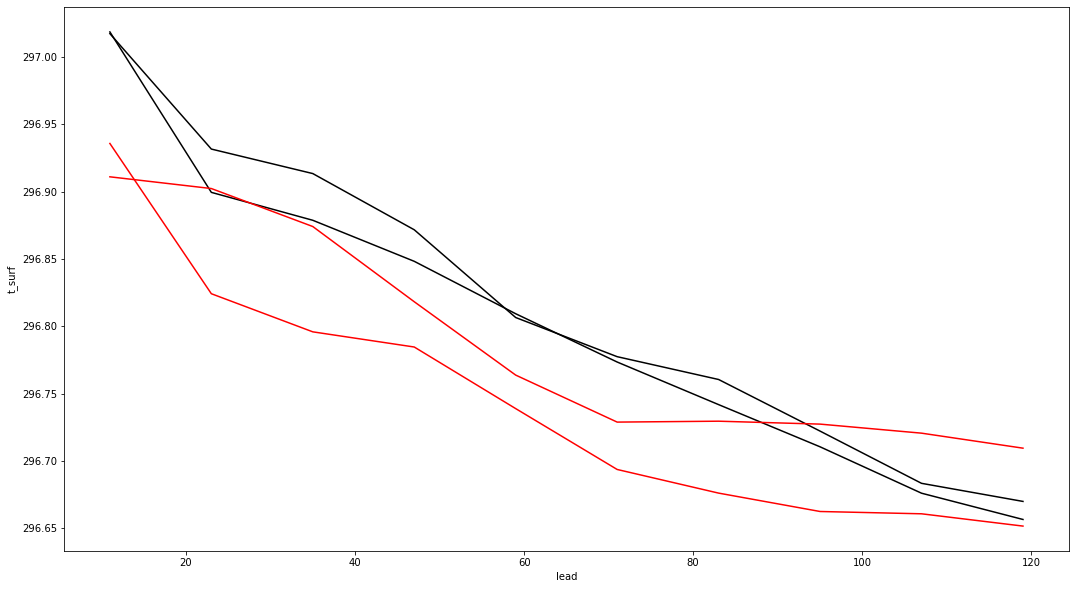

In [67]:
fig = plt.figure(figsize=(18, 10))

PERIOD_1 = slice("1995", "2004")
PERIOD_2 = slice("2005", "2014")

hcst_gbl.sel(init=PERIOD_1).groupby("init.month").mean("init").plot.line(
    x="lead", add_legend=False, color="k"
)

hcst_gbl.sel(init=PERIOD_2).groupby("init.month").mean("init").plot.line(
    x="lead", add_legend=False, color="r"
)

Text(0.5, 1.0, '')

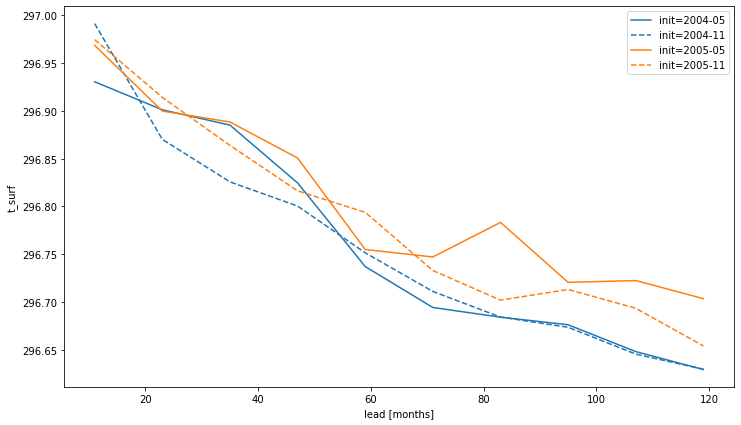

In [68]:
fig = plt.figure(figsize=(12, 7))
hcst_gbl.sel(init="2004-05").plot(color="C0", label="init=2004-05")
hcst_gbl.sel(init="2004-11").plot(color="C0", linestyle="--", label="init=2004-11")
hcst_gbl.sel(init="2005-05").plot(color="C1", label="init=2005-05")
hcst_gbl.sel(init="2005-11").plot(color="C1", linestyle="--", label="init=2005-11")
plt.legend()
plt.xlabel("lead [months]")
plt.title("")

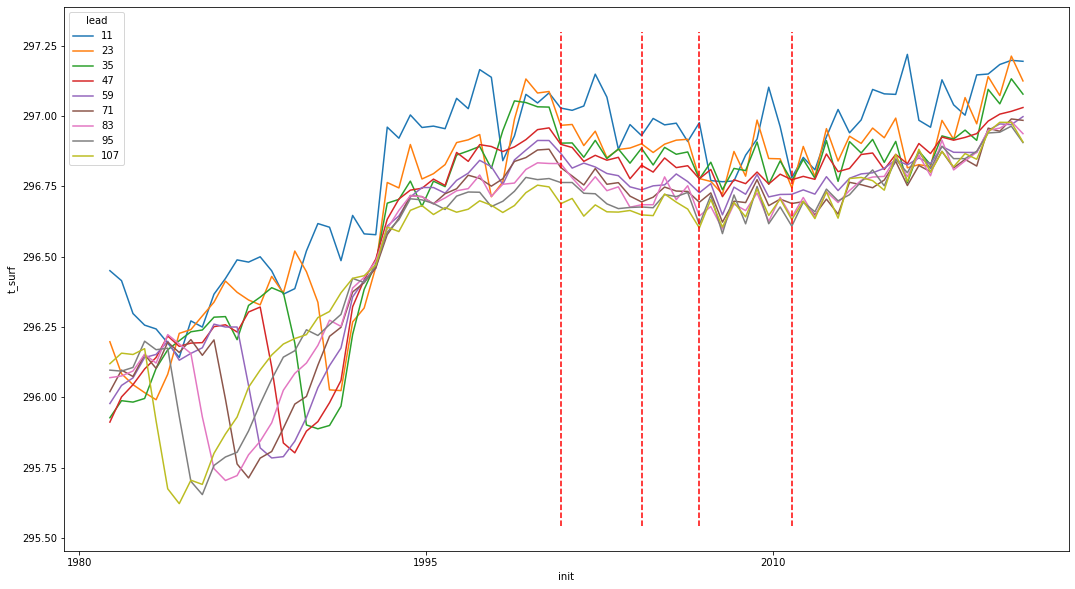

In [69]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
# hcst_gbl[1::2].sel(lead=lead).plot.line(x="init", add_legend=True)
# hcst_gbl[::2].sel(lead=lead).plot.line(x="init", linestyle="--", add_legend=True)
hcst_gbl.sel(lead=lead).plot.line(x="init", add_legend=True)

ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 5, 1),
    cftime.DatetimeJulian(2006, 11, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


# for c, l in enumerate(lead):
#     plt.plot(
#         xr.CFTimeIndex(
#             [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
#         ).shift(-l, freq="MS"),
#         ylim,
#         color=f"C{c}",
#         linestyle="--",
#     )

# Plot May and Nov separately

### May

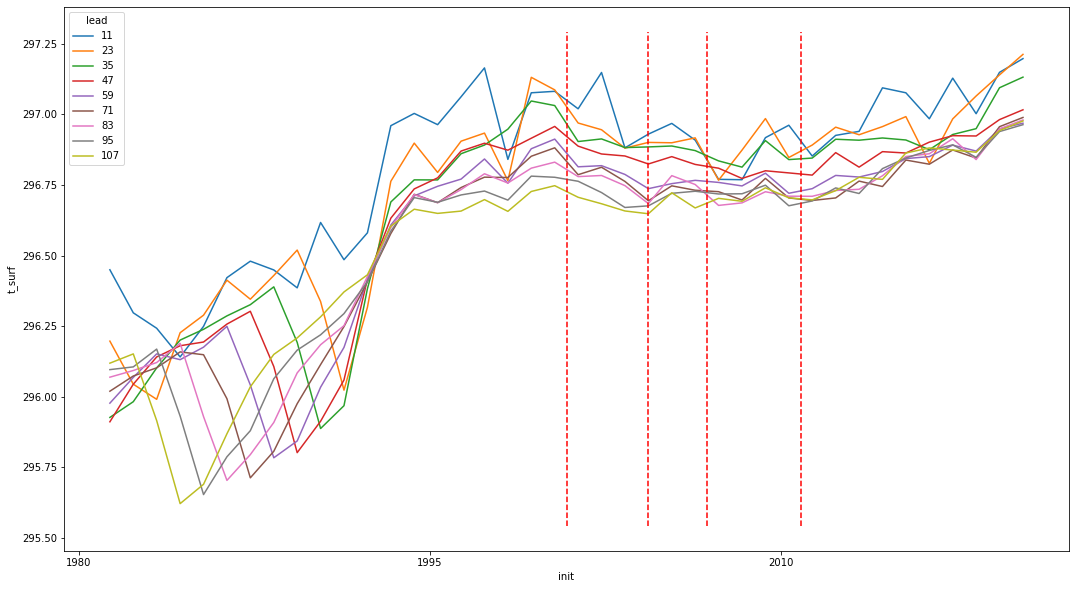

In [70]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
hcst_gbl[::2].sel(lead=lead).plot.line(x="init", add_legend=True)

ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 5, 1),
    cftime.DatetimeJulian(2006, 11, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


# for c, l in enumerate(lead):
#     plt.plot(
#         xr.CFTimeIndex(
#             [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
#         ).shift(-l, freq="MS"),
#         ylim,
#         color=f"C{c}",
#         linestyle="--",
#     )

### Nov

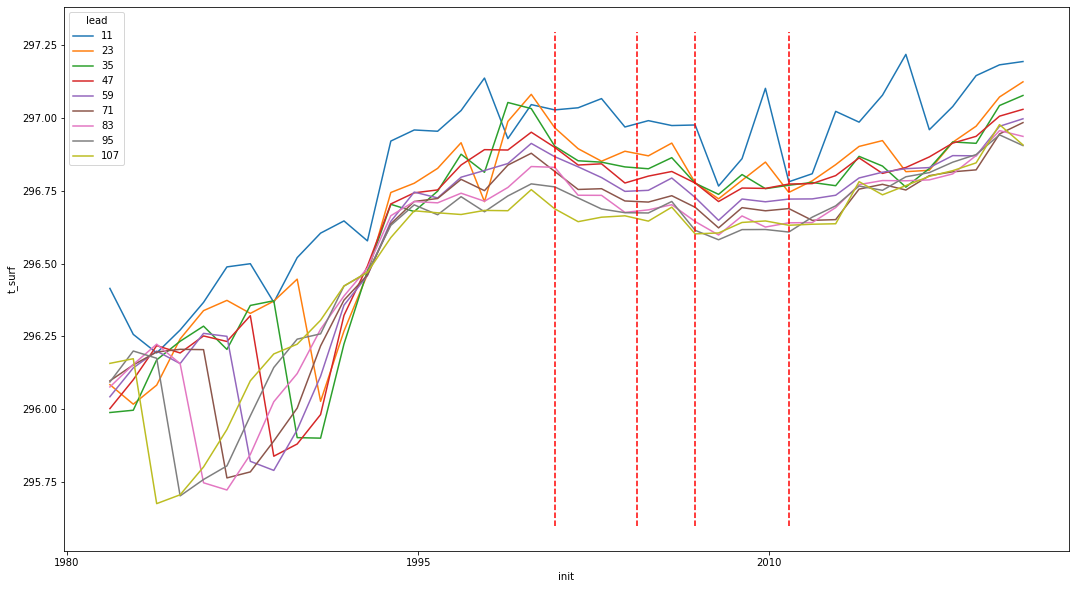

In [71]:
lead = range(11, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
hcst_gbl[1::2].sel(lead=lead).plot.line(x="init", add_legend=True)

ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 5, 1),
    cftime.DatetimeJulian(2006, 11, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


# for c, l in enumerate(lead):
#     plt.plot(
#         xr.CFTimeIndex(
#             [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
#         ).shift(-l, freq="MS"),
#         ylim,
#         color=f"C{c}",
#         linestyle="--",
#     )

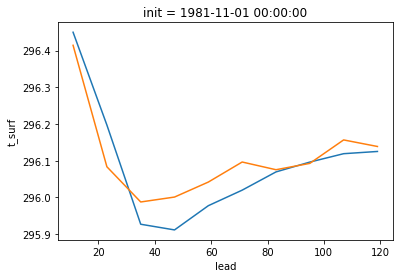

In [72]:
hcst_gbl[0].plot.line(x="lead", color="C0", add_legend=False)
hcst_gbl[1].plot.line(x="lead", color="C1", add_legend=False)

# What about our Fire Susceptibility region

In [18]:
mask = xr.open_dataset(
    "../resources/g.data.xv83.users.ds0092.active_projects.Squire_2021_fire_susceptibility.data.region_mask.ONDJF.10.nc"
)["region_mask"]

In [19]:
hcst_fs = (
    cafe_hcst.where(mask).weighted(cafe_hcst["area"]).mean(["lat", "lon", "member"])
)

/g/data/xv83/users/ds0092/software/miniconda3/envs/xmovie/lib/python3.9/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [20]:
lead = range(47, 119, 12)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 10))
hcst_fs.sel(lead=lead).plot.line(x="init", add_legend=True)
ylim = plt.gca().get_ylim()
# plt.plot(
#     [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
#     ylim,
#     color="k",
#     linestyle="--",
# )

dates = [
    cftime.DatetimeJulian(2000, 11, 1),
    cftime.DatetimeJulian(2004, 11, 1),
    cftime.DatetimeJulian(2005, 5, 1),
    cftime.DatetimeJulian(2010, 11, 1),
]

for date in dates:
    plt.plot(
        [date, date],
        ylim,
        color="r",
        linestyle="--",
    )


for c, l in enumerate(lead):
    plt.plot(
        xr.CFTimeIndex(
            [cftime.DatetimeJulian(1991, 6, 1), cftime.DatetimeJulian(1991, 6, 1)]
        ).shift(-l, freq="MS"),
        ylim,
        color=f"C{c}",
        linestyle="--",
    )

# How does the namelist change across this period?

In [21]:
!diff ../resources/c5-d60-pX-f6-20041101-base.MOM.input.nml ../resources/c5-d60-pX-f6-20050501-base.MOM.input.nml

962,963c962,963
<     basic_ozone_type = 'time_varying'
<     !ozone_dataset_entry=2014, 1, 1, 0, 0, 0,
---
>     basic_ozone_type = 'fixed_year'
>     ozone_dataset_entry=2014, 1, 1, 0, 0, 0,
965c965
<     filename = CM3_CMIP6_1950-2014_O3.nc
---
>     filename = cm3_2014_o3.padded.nc


# This is the point at which we change from time varying ozone forcing (with lead using `CM3_CMIP6_1950-2014_O3.nc`) to fixed year (2014 using `cm3_2014_o3.padded.nc`) forcing

In [13]:
ozone_pre = xr.open_dataset(
    "../resources/c5-d60-pX-f6-20101101-base.MOM.INPUT.CM3_CMIP6_1950-2014_O3.nc"
)["ozone"]

ozone_post = xr.open_dataset(
    "../resources/c5-d60-pX-f6-20101101-base.MOM.INPUT.cm3_2014_o3.padded.nc"
)["ozone"]

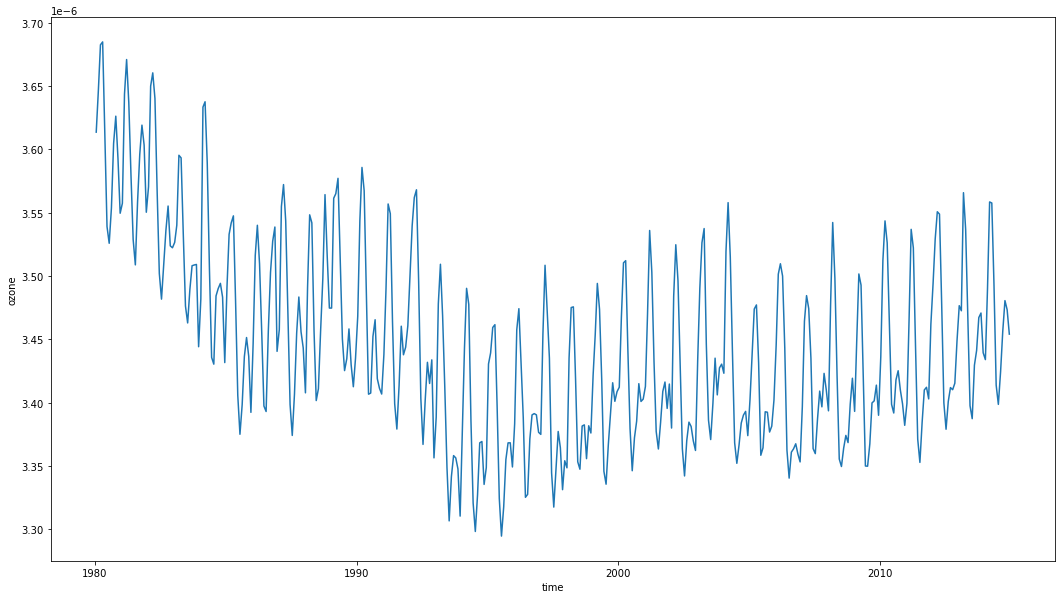

In [14]:
fig = plt.figure(figsize=(18, 10))
ozone_pre.sel(time=slice("1980", None)).mean(["lat", "lon", "pfull"]).plot()

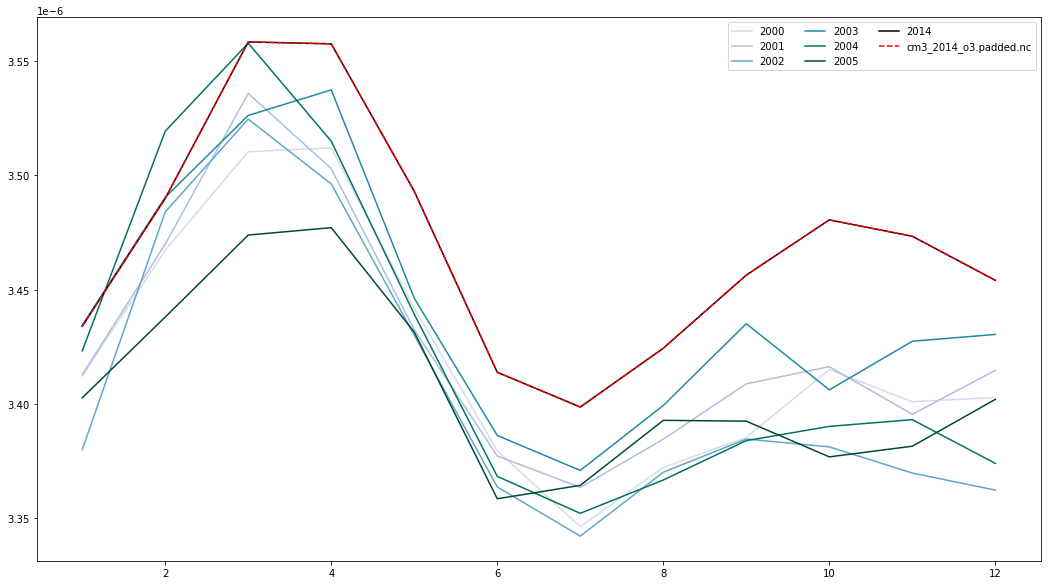

In [16]:
fig = plt.figure(figsize=(18, 10))
from matplotlib.pyplot import cm

level = slice(0, None)  # [10]

gbl_pre = ozone_pre.isel(pfull=level).mean(["lat", "lon", "pfull"])
years = range(2000, 2006)
colors = cm.PuBuGn(np.linspace(0.2, 1, len(years)))
for year, c in zip(years, colors):
    gbl = gbl_pre.sel(time=str(year))
    plt.plot(range(1, 13), gbl, label=str(year), color=c)
plt.plot(range(1, 13), gbl_pre.sel(time="2014"), label="2014", color="k")

gbl_post = ozone_post.isel(pfull=level).mean(["lat", "lon", "pfull"])
plt.plot(
    range(1, 13),
    gbl_post.sel(time="2014"),
    label="cm3_2014_o3.padded.nc",
    color="r",
    linestyle="--",
)

plt.legend(ncol=3)

# What do the historical data do?

In [17]:
data_dir = "/g/data/xv83/users/ds0092/data/CAFE/historical/WIP"
realm = "atmos_isobaric_month.zarr.zip"

In [18]:
cafe_hist = truncate_latitudes(
    xr.open_zarr(f"{data_dir}/c5-d60-pX-hist-19601101/ZARR/{realm}")
)["t_surf"]

cafe_hist = cafe_hist.rename({"ensemble": "member"})  # Req by climpred

cafe_hist = round_to_start_of_month(cafe_hist, dim="time")

# Process annual means to match hcst dataset
cafe_hist = xr.concat(
    [
        coarsen_monthly_to_annual(cafe_hist, cafe_hcst.init[0]),
        coarsen_monthly_to_annual(cafe_hist, cafe_hcst.init[1]),
    ],
    dim="time",
).sortby("time")

/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/pangeo/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 59 times more chunks
  return self.array[key]


In [19]:
hist_gbl = cafe_hist.weighted(cafe_hist["area"]).mean(["lat", "lon", "member"])

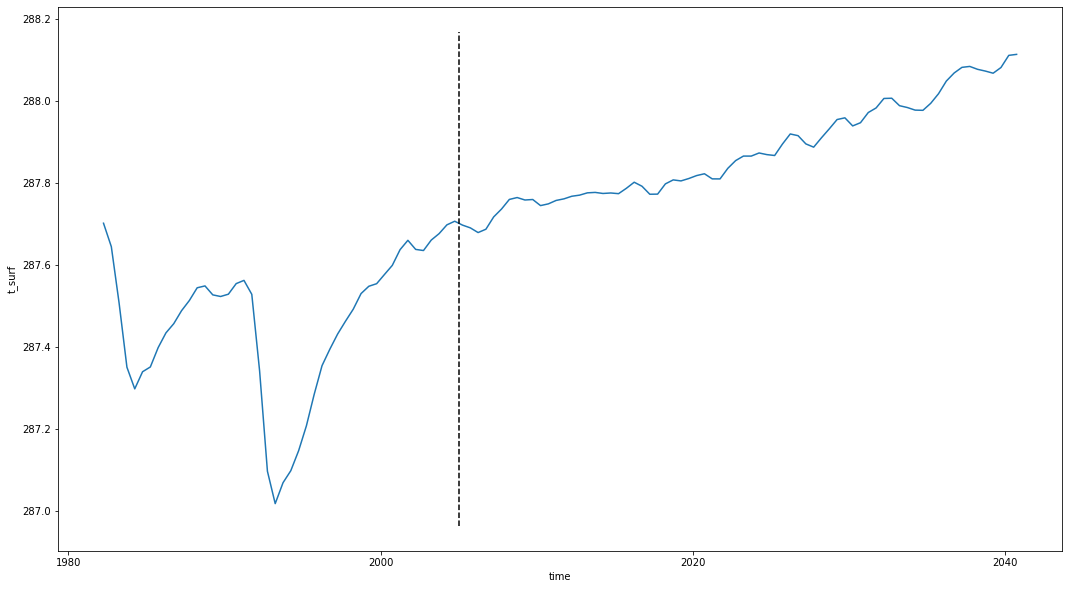

In [20]:
fig = plt.figure(figsize=(18, 10))

hist_gbl.plot()

ylim = plt.gca().get_ylim()
plt.plot(
    [cftime.DatetimeJulian(2005, 1, 1), cftime.DatetimeJulian(2005, 1, 1)],
    ylim,
    color="k",
    linestyle="--",
)

# Compare forecasts with and without timevarying ozone forcing

In [6]:
realm = "atmos_isobaric_month.zarr.zip"

path = "/g/data/xv83/users/ds0092/data/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-20040501-fixed_ozone/ZARR/"
files = sorted(glob.glob(f"{path}mem*/{realm}"))
fixed = open_mfzarr(files)[["t_surf", "qo3_col"]].compute()

path = "/g/data/xv83/dcfp/CAFE-f6"
tv = xr.open_zarr(f"{path}/c5-d60-pX-f6-20040501/{realm}")[
    ["t_surf", "qo3_col"]
].compute()

In [7]:
gbl_fixed = (
    coarsen_monthly_to_annual(fixed["t_surf"])
    .weighted(fixed["area"])
    .mean(["lat", "lon", "ensemble"])
)
gbl_tv = (
    coarsen_monthly_to_annual(tv["t_surf"])
    .weighted(tv["area"])
    .mean(["lat", "lon", "ensemble"])
)

Text(0.5, 1.0, 'Global mean forecast initialised 2004-05-01')

<Figure size 1080x504 with 0 Axes>

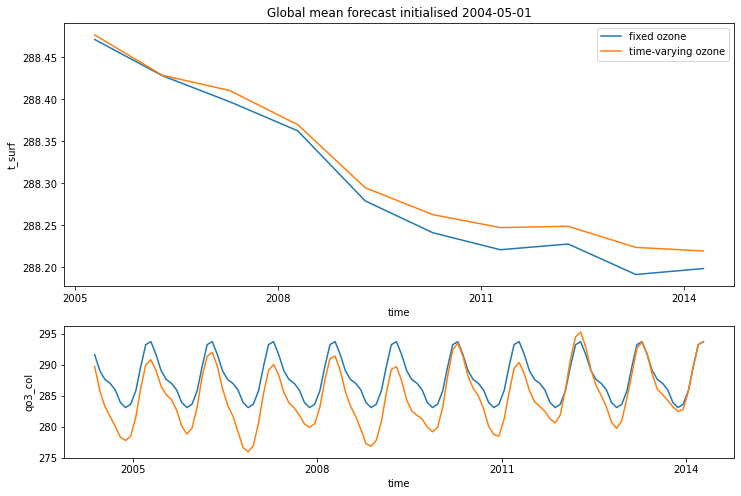

In [8]:
fig = plt.figure(figsize=(15, 7))

fig, (ax0, ax1) = plt.subplots(
    2,
    1,
    gridspec_kw={
        "height_ratios": [
            2,
            1,
        ]
    },
    figsize=(12, 8),
)

gbl_fixed.plot(ax=ax0, label="fixed ozone")
gbl_tv.plot(ax=ax0, label="time-varying ozone")
ax0.legend()

fixed["qo3_col"].weighted(fixed["area"]).mean(["lat", "lon", "ensemble"]).plot(ax=ax1)
tv["qo3_col"].weighted(tv["area"]).mean(["lat", "lon", "ensemble"]).plot(ax=ax1)

ax0.set_title("Global mean forecast initialised 2004-05-01")

# Compare same forecasts run by me and Vassili

In [9]:
realm = "atmos_isobaric_month.zarr.zip"

path = "/g/data/xv83/users/ds0092/data/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-20061101-rerun/ZARR/"
files = sorted(glob.glob(f"{path}mem*/{realm}"))
dougie = open_mfzarr(files)[["t_surf", "qo3_col"]].compute()
completed_members = dougie.ensemble

path = "/g/data/xv83/dcfp/CAFE-f6"
vassili = xr.open_zarr(f"{path}/c5-d60-pX-f6-20061101/{realm}")[
    ["t_surf", "qo3_col"]
].compute()
vassili = vassili.sel(ensemble=completed_members)

In [27]:
gbl_dougie = (
    coarsen_monthly_to_annual(dougie["t_surf"])
    .weighted(dougie["area"])
    .mean(["lat", "lon", "ensemble"])
)
gbl_vassili = (
    coarsen_monthly_to_annual(vassili["t_surf"])
    .weighted(vassili["area"])
    .mean(["lat", "lon", "ensemble"])
)

Text(0.5, 1.0, 'Global mean forecast initialised 2006-11-01')

<Figure size 1080x504 with 0 Axes>

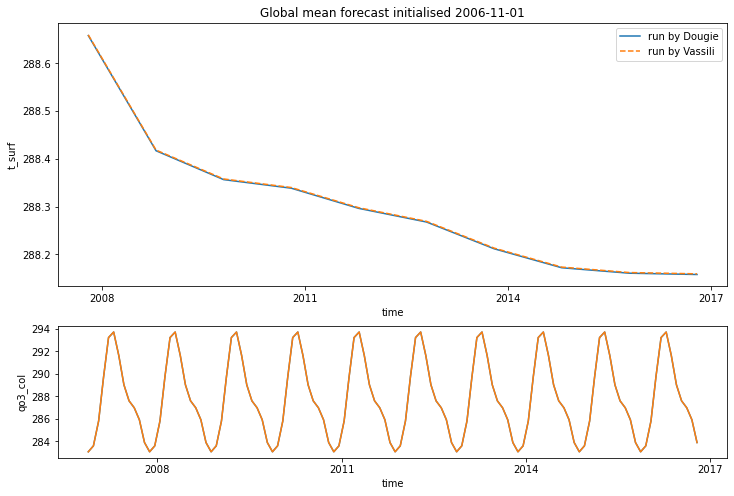

In [28]:
fig = plt.figure(figsize=(15, 7))

fig, (ax0, ax1) = plt.subplots(
    2,
    1,
    gridspec_kw={
        "height_ratios": [
            2,
            1,
        ]
    },
    figsize=(12, 8),
)

gbl_dougie.plot(ax=ax0, label="run by Dougie")
gbl_vassili.plot(ax=ax0, label="run by Vassili", linestyle="--")
ax0.legend()

dougie["qo3_col"].weighted(dougie["area"]).mean(["lat", "lon", "ensemble"]).plot(ax=ax1)
vassili["qo3_col"].weighted(vassili["area"]).mean(["lat", "lon", "ensemble"]).plot(
    ax=ax1
)

ax0.set_title("Global mean forecast initialised 2006-11-01")

# How do fields at subsequent lead times compare to lead 0? I.e. where is the drift?

In [73]:
lead = 5
period = slice("1987", "2021")

In [74]:
ref = (
    cafe_hcst.sel(lat=slice(-40, 40))
    .mean("member")
    .isel(lead=0)
    .swap_dims({"init": "time"})
    .sel(time=period)
)
cmp = (
    cafe_hcst.sel(lat=slice(-40, 40))
    .mean("member")
    .isel(lead=lead)
    .swap_dims({"init": "time"})
    .sel(time=period)
)

diff = (cmp - ref).compute()
diff = diff.assign_coords({"init_date": cmp.init})

In [77]:
start_month = "May"
to_drop = ["average_DT", "average_T1", "average_T2"]

if start_month == "May":
    field = diff.where(diff.time.dt.month == 4, drop=True).rename("field").drop(to_drop)
    ts = (
        hcst_gbl.where(hcst_gbl.init.dt.month == 5, drop=True)
        .rename("ts")
        .drop(to_drop)
    )
elif start_month == "Nov":
    field = (
        diff.where(diff.time.dt.month == 10, drop=True).rename("field").drop(to_drop)
    )
    ts = (
        hcst_gbl.where(hcst_gbl.init.dt.month == 11, drop=True)
        .rename("ts")
        .drop(to_drop)
        .rename({"time": "times"})
    )

to_plot = xr.merge([field, ts]).compute()

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def make_plot(ds, fig, tt, *args, **kwargs):
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.6, 1])
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(180))
    ax2 = fig.add_subplot(gs[1])

    # Map axis
    data = ds["field"].isel({"time": tt}).rename("t_surf")
    init = data.init_date
    time = data.time
    im = data.plot(
        ax=ax1,
        vmin=kwargs["vmin"],
        vmax=kwargs["vmax"],
        cmap="RdBu_r",
        transform=ccrs.PlateCarree(),
        add_colorbar=True,
    )
    im.axes.coastlines(color="k")
    ax1.set_title(
        f"Difference between lead {lead} and 0 {start_month} annual mean forecasts"
        + "\n"
        + f"Comparison time: {time.item()}"
        + "\n"
        + f"Initial date of lead {lead} forecast: {init.item()}",
        fontsize=12,
    )

    #     divider = make_axes_locatable(ax1)
    #     cax = divider.append_axes("right", size="2%", pad=0.1)
    #     fig.colorbar(im, cax=cax, orientation="vertical")

    # Time series
    data = ds["ts"].rename("Global t_surf")
    data.plot.line(
        ax=ax2, x="init", add_legend=False, color="grey", label="__nolabel__"
    )
    data.isel(lead=0).plot.line(
        ax=ax2, x="init", add_legend=False, color="k", label="lead 0"
    )
    data.isel(lead=lead).plot.line(
        ax=ax2, x="init", add_legend=False, color="C0", label=f"lead {lead}"
    )
    ylims = ax2.get_ylim()
    init_index = np.where(data.init.values == init.item())[0]
    assert data.isel(init=init_index).init.item() == init.item()
    ax2.plot(
        [init.item(), init.item()],
        ylims,
        color="k",
        linestyle="--",
    )
    ax2.plot(
        [
            data.isel(init=init_index + lead).init.item(),
            data.isel(init=init_index).init.item(),
        ],
        [
            data.isel(init=init_index + lead).isel(lead=0),
            data.isel(init=init_index).isel(lead=lead),
        ],
        color="C1",
        marker="o",
    )
    ax2.set_title("")
    ax2.legend(fontsize=10, loc="lower right")

    fig.subplots_adjust(hspace=0.1)

    return None, None


mov_custom = Movie(
    to_plot,
    make_plot,
    vmin=-3,
    vmax=3,
    pixelwidth=1420,
    pixelheight=1080,
    dpi=160,
    input_check=False,
)
mov_custom.save(
    f"{start_month}_starts.Lead_{lead}.Tropics.mp4", overwrite_existing=True
)

Movie created at May_starts.Lead_5.Tropics.mp4
